# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


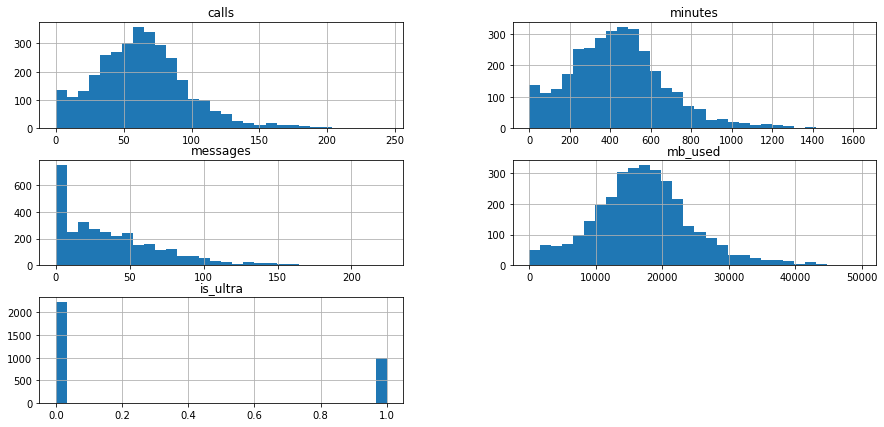

In [7]:
df.hist(bins=30, figsize=(15, 7));

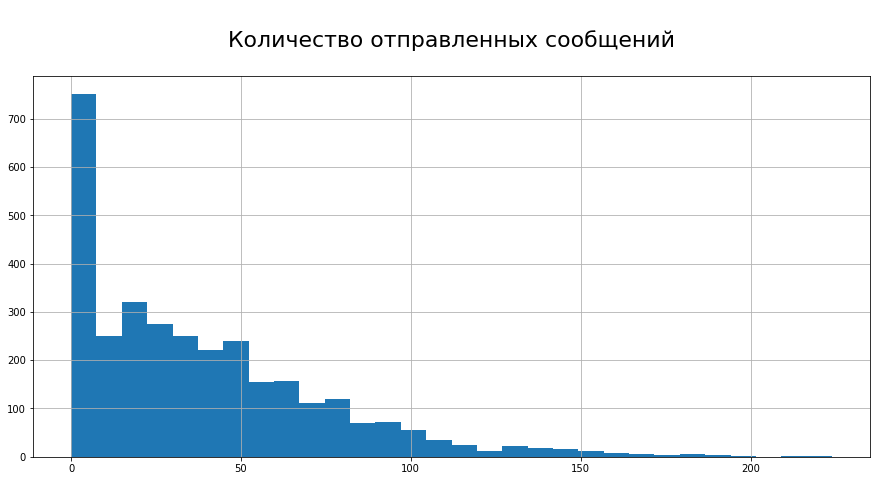

In [8]:
df.messages.hist(bins=30, figsize=(15, 7)).set_title('\n' + 'Количество отправленных сообщений' + '\n', fontsize=22);

### Вывод

В данных обработки не треубется так как она была уже проведена ранее. Данные содержат в себе исключительно числовые данные, 5 признаков и одного целевого столбца, были постренные гистограммы, на одной из них видно, что пользователей тарифов "Смарт" почти в два раза больше пользователей тарифа "Ультра" (вероятно, из-за стоимости), всего записей в датасете чуть меньше двух тысяч, также заметно, что почти половина пользователей либо не пользуется обычными смс-сообщениями, либо отправляет их в минимальном количестве

In [9]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

## Разбейте данные на выборки

In [10]:
df_train, df_valid_test = train_test_split(
    df, test_size=0.40, random_state=12345)

df_valid, df_test = train_test_split(
    df_valid_test, test_size=0.50, random_state=12345)

Так как спрятанной выборки нет, то от основной для валидационной отделяют 20%, и 20% для тестовой, соотношение получается 3/1/1

(обучающая 60%, валидационная 20%, тестовая 20%)

In [11]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [12]:
features_train.shape

(1928, 4)

In [13]:
features_valid.shape

(643, 4)

In [14]:
features_test.shape

(643, 4)

## Исследуйте модели

### Дерево решений

Первая модель - дерево решений, с подбором различных гиперпараметров через цикл for (на самом деле перепробованы все возможные гиперпараметры, но результата это не дало, с целью сохранения времени, решено оставить перебор только трех гиперпараметров, наиболее существенных для данного датафрейма):

In [15]:
best_model_tree = None
best_result_tree_valid = 0
for criterion in ['gini', 'entropy']:
    for max_features in ['auto', 'sqrt', 'log2']:
        for depth in range(1, 10):
            model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth,
                                                criterion=criterion, max_features=max_features)
            model_tree.fit(features_train, target_train)
            train_predictions = model_tree.predict(features_valid)
            result = accuracy_score(target_valid, train_predictions)
            if result > best_result_tree_valid:
                best_result_tree_valid = result
                best_model_tree = model_tree

In [16]:
best_model_tree

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       random_state=12345)

In [17]:
best_result_tree_valid

0.7916018662519441

### Случайный лес

Следующая модель - случайный лес, с деревьями решений, подбор аналогичный предыдущему:

In [18]:
best_model_est = None
best_result_est = 0
for criterion in ['entropy', 'gini']:
    for est in range(70, 120, 10):
        for depth in range(1, 56, 10):
            model_est = RandomForestClassifier(random_state=12345,
                                               n_estimators=est,
                                               max_depth=depth,
                                               criterion=criterion)
            model_est.fit(features_train, target_train)
            train_predictions = model_tree.predict(features_valid)
            result = model_est.score(features_valid, target_valid)
            if result > best_result_est:
                best_model_est = model_est
                best_result_est = result

In [19]:
best_model_est

RandomForestClassifier(criterion='entropy', max_depth=31, n_estimators=80,
                       random_state=12345)

In [20]:
best_result_est

0.7931570762052877

#### Перебор гиперпараметров случайного леса (доп)

*(Не совсем по теме пройденных уроков, но я так увлекся этой темой, что в погоне за лучшими показателями даже оставлял на длительное время перебор гиперпараметров, буду очень признателен, если подскажешь в каком направлении двигаться правильнее))*

Так как данная модель показала лучший результат по сравнению с одним деревом, было решено использовать функцию RandomizedSearchCV() для подбора случайных параметров (из пространства достаточно широких параметров), для примерной обрисовки, чтобы потом попытаться сузить пространство для более тщательного подбора, увеличения быстродействия и подбора лучших параметров (хотя тут не угадаешь, какие параметры в какой момент окажут значительное влияние, ведь соседкие параметры могут быть совершенно разными)

In [21]:
# Пространство гиперпарметров
model_est_space={'max_depth':list(np.arange(10, 51, step=10)) + [None],
              'n_estimators':np.arange(170, 401, step=10),
              'max_features':randint(1,3),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,3),
              'min_samples_split':np.arange(2, 6, step=2)
         }

# Так как нигде не нашел с помощью какого параметра можно назначить тестирование,
# решил скормить весь датасет целиком этой функции, в документации прочитал, что эта функция уже содержит в себе
# все необходимое, поэтому отделил только ту часть которая должна оставаться скрытой - тестовую
# Следуя этой логике отделил только 20 процентов под тест, для соблюдения 3/1/1
df_train_random, df_test_random = train_test_split(df, test_size=0.20, random_state=12345)

df_features_random = df_train_random.drop(['is_ultra'], axis=1)
df_target_random = df_train_random['is_ultra']

features_test_random = df_test_random.drop(['is_ultra'], axis=1)
target_test_random = df_test_random['is_ultra']

# Число итераций уменьшено, так как работа здесь была закончена
model_est_random = RandomizedSearchCV(RandomForestClassifier(random_state=12345), model_est_space,
                                                n_iter=2, scoring='accuracy', n_jobs=-1, cv=6)

model_est_random.fit(df_features_random, df_target_random)

RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc61eff5f40>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc61f07fbb0>,
                                        'min_samples_split': array([2, 4]),
                                        'n_estimators': array([170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290,
       300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400])},
                   scoring='accuracy')

In [22]:
# Точность модели на валидационных данных, как я понимаю
model_est_random.best_score_

0.814474725689679

In [23]:
model_est_random.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 360}

Случайно были подобраны (из большого числа итераций) следующие гиперпараметры:

- 'criterion': 'entropy',
- 'max_depth': 10,
- 'max_features': 2,
- 'min_samples_leaf': 1,
- 'min_samples_split': 4,
- 'n_estimators': 270

Точность модели на тестовых данных (тестовых в рандомайзере) составила - 0.8040435458786936

In [24]:
model_est = RandomForestClassifier(
    random_state=12345,
    criterion='entropy',
    max_depth=10,
    max_features=2,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=270
)

# Обучение и тест на валидационных данных новой модели, не с рандомайзера, а именно на начальном разделении 
# с подобранными случайными параметрами
model_est.fit(features_train, target_train)
best_result_est = model_est.score(features_valid, target_valid)
best_result_est

0.7978227060653188

In [25]:
%%time
# Код ревьюера
parameters = {
    'n_estimators': range(50, 121, 5),
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 4),
}

model = RandomForestClassifier(random_state=96)

metrics = ['f1', 'roc_auc']

# Обрати внимание я указал в scoring список мужных метрик,
# А в refit указал 'f1', теперь GridSearchCV будет оптимизировать эту метрику
search = RandomizedSearchCV(model, parameters, n_iter=1, cv=4, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_
# Печатаем лучшие значения метрик и гиперпараметры
print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.5506
AUC-ROC on VALID: 0.7660
n_estimators        55
min_samples_leaf     1
max_depth            2
dtype: int64
CPU times: user 495 ms, sys: 4 ms, total: 499 ms
Wall time: 507 ms


In [26]:
model_est = RandomForestClassifier(
    random_state=96,
    max_depth=9,
    min_samples_leaf=3,
    n_estimators=50
)

# Обучение и тест на валидационных данных новой модели, не с рандомайзера, а именно на начальном разделении 
# с подобранными случайными параметрами
model_est.fit(features_train, target_train)
best_result_est = model_est.score(features_valid, target_valid)
best_result_est

0.8009331259720062

### Логистическая регрессия

In [76]:
from sklearn.linear_model import LinearRegression
model_logistic_regression = LinearRegression();
model.distancemetric='manhattan'
model_logistic_regression.fit(features_train, target_train);

In [77]:
predict_valid = model_logistic_regression.predict(features_valid)
predict_valid = np.round(predict_valid)
predict_test = model_logistic_regression.predict(features_test)
predict_test = np.round(predict_test)

In [78]:
logistic_regression_result_valid = accuracy_score(target_valid, predict_valid)
logistic_regression_result_valid

0.7573872472783826

### Сравнение точности моделей

In [79]:
list_resuts_valid = [best_result_tree_valid, best_result_est, logistic_regression_result_valid]
results_valid = pd.Series(list_resuts_valid, index=['Дерево решений', 'Лес', 'Логистическая регрессия'])

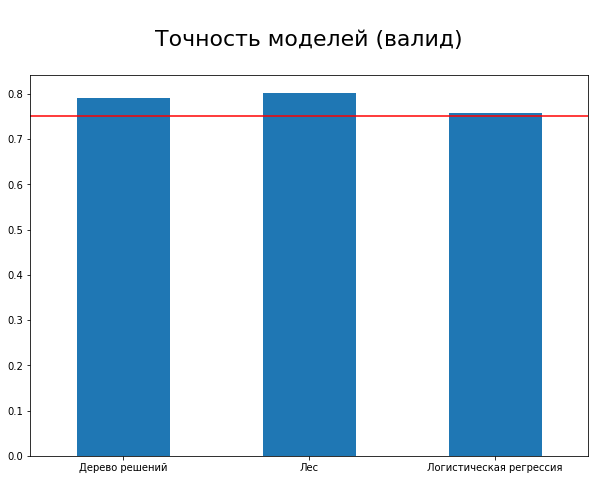

In [80]:
results_valid.plot(x=results_valid.index,
                   y=results_valid.values,
                   kind='bar',
                   figsize=(10, 7),
                   rot=0);

plt.title("\n"+'Точность моделей (валид)'+"\n", fontsize=22)
plt.axhline(y=0.75, color='red');

По требуемой точности - 75% (красная линия), подходят все три модели, однако, лучшей из них является случайный лес, с точностью на валидационных данных - 79.8%

## Проверьте модель на тестовой выборке

Точность дерева решений на тесте:

In [81]:
best_result_tree_test = model_tree.score(features_test, target_test)
best_result_tree_test

0.7869362363919129

Точность случайного леса на тесте:

In [82]:
best_result_est_test = model_est.score(features_test, target_test)
best_result_est_test

0.8040435458786936

Точность логистической регрессии на тесте:

In [83]:
logistic_regression_result_test = accuracy_score(target_test, predict_test)
logistic_regression_result_test

0.7402799377916018

In [84]:
list_results_test = [best_result_tree_test, best_result_est_test, logistic_regression_result_test]
results_test = pd.Series(list_results_test, index=['Дерево решений', 'Лес', 'Логистическая регрессия'])

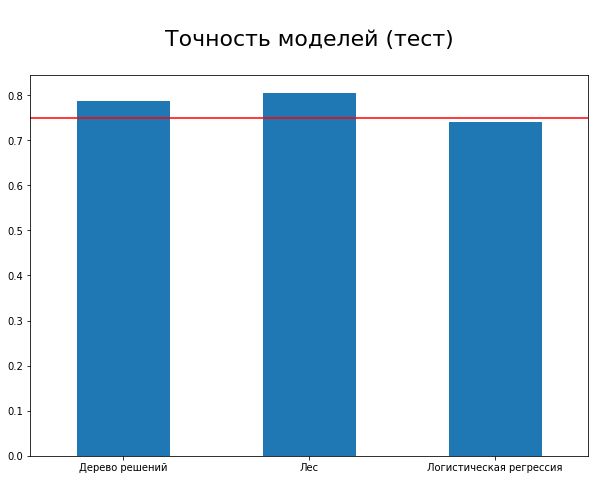

In [85]:
results_test.plot(x=results_test.index,
                   y=results_test.values,
                   kind='bar',
                   figsize=(10, 7),
                   rot=0);

plt.title("\n"+'Точность моделей (тест)'+"\n", fontsize=22)
plt.axhline(y=0.75, color='red');

На тестовых данных проходит по точности, только две модели - дерево решений и случайный лес, лучшим так и остался случайный лес с точност. около 81%

In [86]:
features_full_train = pd.concat([features_train, features_valid])
target_full_train = pd.concat([target_train, target_valid])

In [87]:
model_est = RandomForestClassifier(
    random_state=12345,
    criterion='entropy',
    max_depth=10,
    max_features=2,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=270,
    class_weight={1: 1, 0: 1}
)

model_est.fit(features_full_train, target_full_train)
model_est.score(features_test, target_test)

0.8055987558320373

In [88]:
model_tree = DecisionTreeClassifier(
    random_state=12345,
    criterion='entropy',
    max_depth=5,
    max_features='auto'
)

model_tree.fit(features_full_train, target_full_train)
model_tree.score(features_test, target_test)

0.7853810264385692

## (бонус) Проверьте модели на адекватность

*Подскажие пожалуйста в каком направлении двигаться я искал в интернете, но там нашел только проверка модели для решений задач по регрессии, а не классификации*

Оценили адекватность полученных моделей прошедших минимум в 0.75, всего две модели. Проверили спобом "глупой" модели, создали список с нулями, равный по длине тестовому, представили этот список как предсказания этой "глупой" модели и сравнили с полученными ранее моделями:

In [89]:
dummy_prediction = np.zeros(643)
accuracy_score(target_test, dummy_prediction)

0.6842923794712286

Около 68 процентов точности глупой модели.

Показатель лучшей модели - случайного леса:

In [90]:
model_est_predictions = model_est.predict(features_test)
accuracy_score(target_test, model_est_predictions)

0.8055987558320373

Показатель дерева решений:

In [91]:
model_tree_predictions = model_tree.predict(features_test)
accuracy_score(target_test, model_tree_predictions)

0.7853810264385692

Как увидели, что обе модели прошли проверку на адекватность, чуть более десяти процентов точности составляет разница между "глупой" модели и модели по случайному лесу, значит, модель обладает предиктивной силой и может считаться адекватной

## Вывод

Исходные данные как и было описано выше в выводе не требовали предобработки так как она была проведена ранее, исследовали три модели - дерево решений, случайный лес и логистическая регрессия для задач классификации. Лучшей из них явилась модель случайного леса, подошли под условия поставленной задачи (не менее 75 процентов точности) только две из них - случайный лес (около 80 процентов) и дерево решений (чуть менее 80 процентов), на тестовых данных.

В целом, можно сказать, что возможно, есть пути улучшения модели, но задача выполнена. Так можно поработать с признаками - дополнительно их классифицировать, например, попробовать дополнительно классифицировать пользователей отправляющих много смс и мало отправляющих или совсем не отправляющих, также можно попробоать классифицировать и по другим признакам, например, по интернет-трафику или звонкам, а затем обучить модель.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
